In [1]:
import numpy as np
import matplotlib.pyplot as plt
import builtins
import types


def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )


dora = ("#2C94C8", "#EA6CA2", "#d9bf4a", "#DB4237",
        "#DACDBD", "#DE927C", "#E1E8F1", "#919191")
dora = dora*10

# 関数定義

In [2]:
@noglobal
def free_energy(phi, coeffs):
    """
    Calculate the Flory-Huggins free energy.

    Parameters:
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the free energy calculation.

    Returns:
    float: The calculated free energy.
    """
    if not 0 <= phi.all() <= 1:
        raise ValueError("Volume fraction (phi) must be between 0 and 1.")
    chi = coeffs[0]
    N1 = coeffs[1]
    N2 = coeffs[2]
    return chi*phi*(1-phi) + phi*np.log(phi)/N1 + (1-phi)*np.log(1-phi)/N2


@noglobal
def spinodal(coeffs):
    """
    Calculate the spinodal points.

    Parameters:
    coeffs (list): Coefficients for the spinodal calculation.

    Returns:
    list: The calculated spinodal points.
    """
    chi = coeffs[0]
    N1 = coeffs[1]
    N2 = coeffs[2]
    alpha = 2*chi*N1*N2
    common = (alpha+N2-N1) / (2*alpha)
    r = np.sqrt((alpha+N2-N1)**2-4*alpha*N2)/(2*alpha)
    return common+r, common-r


@noglobal
def dfdphi(phi, coeffs):
    """
    Calculate the derivative of the free energy with respect to the volume fraction.

    Parameters:
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the derivative calculation.

    Returns:
    float: The calculated derivative.
    """
    chi = coeffs[0]
    N1 = coeffs[1]
    N2 = coeffs[2]
    return chi*(1-2*phi) + (1+np.log(phi))/N1 - (1+np.log(1-phi))/N2


@noglobal
def fe_tangent(phi, p0, coeffs):
    """
    Calculate the tangent of the free energy.

    Parameters:
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the tangent calculation.

    Returns:
    float: The calculated tangent.
    """
    chi = dfdphi(p0, coeffs)*(phi-p0) + free_energy(p0, coeffs)
    return chi


# @noglobal
# def j1(phi, coeffs):
#     """
#     Calculate the first element of the Jacobian matrix.

#     Parameters:
#     phi (float): Volume fraction.
#     coeffs (list): Coefficients for the Jacobian calculation.

#     Returns:
#     float: The calculated first element of the Jacobian matrix.
#     """
#     chi = coeffs[0]
#     N1 = coeffs[1]
#     N2 = coeffs[2]
#     return -2*chi + 1/(N1*phi) + 1/(N2*phi)


# @noglobal
# def j2(phi, coeffs):
#     """
#     Calculate the second element of the Jacobian matrix.

#     Parameters:
#     phi (float): Volume fraction.
#     coeffs (list): Coefficients for the Jacobian calculation.

#     Returns:
#     float: The calculated second element of the Jacobian matrix.
#     """
#     chi = coeffs[0]
#     N1 = coeffs[1]
#     N2 = coeffs[2]
#     return - (N2*(1-phi)**2 + N1*phi**2)/(N1*N2*phi*(1-phi)**2)


@noglobal
def calculate_derivative(order, phi, coeffs):
    """
    Calculate the first/second element of the Jacobian matrix.

    Parameters:
    order (int): order of derivative,
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the Jacobian calculation.

    Returns:
    float: The calculated first/second element of the Jacobian matrix.
    """    
    chi = coeffs[0]
    N1 = coeffs[1]
    N2 = coeffs[2]
    if order == 1:
        # Calculate the first derivative
        return -2*chi + 1/(N1*phi) + 1/(N2*phi)
    elif order == 2:
        # Calculate the second derivative
        return - (N2*(1-phi)**2 + N1*phi**2)/(N1*N2*phi*(1-phi)**2)
    else:
        raise ValueError("Invalid order for derivative calculation")


# @noglobal
# def fx(psi, coeffs):
#     """
#     Calculate the function for the Newton method.

#     Parameters:
#     phi (float): Volume fraction.
#     coeffs (list): Coefficients for the function calculation.

#     Returns:
#     float: The calculated function value.
#     """
#     return dfdphi(psi[0], coeffs) - dfdphi(psi[1], coeffs)


# @noglobal
# def fy(psi, coeffs):
#     """
#     Calculate the function for the Newton method.

#     Parameters:
#     phi (float): Volume fraction.
#     coeffs (list): Coefficients for the function calculation.

#     Returns:
#     float: The calculated function value.
#     """
#     return free_energy(psi[0], coeffs) - free_energy(psi[1], coeffs) - psi[0]*dfdphi(psi[0], coeffs) + psi[1]*dfdphi(psi[1], coeffs)


@noglobal
def fxfy(psi, coeffs):
    """
    Calculate the vector of functions for the Newton method.

    Parameters:
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the function calculation.

    Returns:
    list: The calculated vector of function values.
    """
#     x = fx(psi, coeffs)
#     y = fy(psi, coeffs)
    x = dfdphi(psi[0], coeffs) - dfdphi(psi[1], coeffs)
    y = free_energy(psi[0], coeffs) - free_energy(psi[1], coeffs) - psi[0]*dfdphi(psi[0], coeffs) + psi[1]*dfdphi(psi[1], coeffs)
    return np.array([x, y])


@noglobal
def jacobian(psi, coeffs):
    """
    Calculate the Jacobian matrix.

    Parameters:
    phi (float): Volume fraction.
    coeffs (list): Coefficients for the Jacobian calculation.

    Returns:
    list: The calculated Jacobian matrix.
    """
    p1, p2 = psi
    J11 = calculate_derivative(1, p1, coeffs)
    J12 = -calculate_derivative(1, p2, coeffs)
    J21 = calculate_derivative(2, p1, coeffs)
    J22 = -calculate_derivative(2, p2, coeffs)
#     J11 = j1(p1, coeffs)
#     J12 = -j1(p2, coeffs)
#     J21 = j2(p1, coeffs)
#     J22 = -j2(p2, coeffs)
    return np.array([[J11, J12], [J21, J22]])

# 共通接線を計算

In [3]:
@noglobal
def binodal(coeffs, psi=np.array([-1, -1]), verbose=False, eps=1e-10, max_loop=1e9):
    """
    Calculate the binodal curve.

    Parameters:
    coeffs (list): Coefficients for the binodal curve calculation.

    Returns:
    list: The calculated binodal curve.
    """
    # 2d newton method
    if psi[0] < 0.0:
        p1, p2 = spinodal(coeffs)
        psi = np.array([p1, p2])

    delta = np.array([1e1, 1e1])  # initial value of inv(J)*f
    k = 0  # index of loop
    flag = True
    while (abs(delta[0]) > eps and abs(delta[1]) > eps):
        try:
            J = jacobian(psi, coeffs)
            invJ = np.linalg.inv(J)
            f = fxfy(psi, coeffs)
            delta = np.dot(invJ, f)
            while(psi[0]-delta[0] > 1.0 or psi[1]-delta[1] < 0.0):
                # 0<phi<1に収まらないとlog(phi), log(1-phi)が１nanになるのでdeltaを適度に小さくする
                delta *= 0.5
            psi = psi - delta
        except:
            print('could not calculate inverse J')
            print('J = ')
            print(J)
            print('delta = ')
            print(delta)
            print('psi = ')
            print(psi)
            flag = False
            break

        if (verbose and k % 10000 == 0):
            print('k = %s:' % k)
            print('dphi1 = {:>12.5e}'.format(
                delta[0]), ',\t dphi2 = {:>12.5e}'.format(delta[1]))
            print('phi1  = {:>12.5e}'.format(
                psi[0]),   ',\t phi2  = {:>12.5e}'.format(psi[1]))
        k += 1
        if (k > max_loop):
            print('could not convergence')
            flag = False
            break
    return psi, flag

# 共通接線計算方法

C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_32636\1492746299.py:18: RuntimeWarning: divide by zero encountered in log
  return chi*phi*(1-phi) + phi*np.log(phi)/N1 + (1-phi)*np.log(1-phi)/N2
C:\Users\Administrator\AppData\Local\Temp\3\ipykernel_32636\1492746299.py:18: RuntimeWarning: invalid value encountered in multiply
  return chi*phi*(1-phi) + phi*np.log(phi)/N1 + (1-phi)*np.log(1-phi)/N2


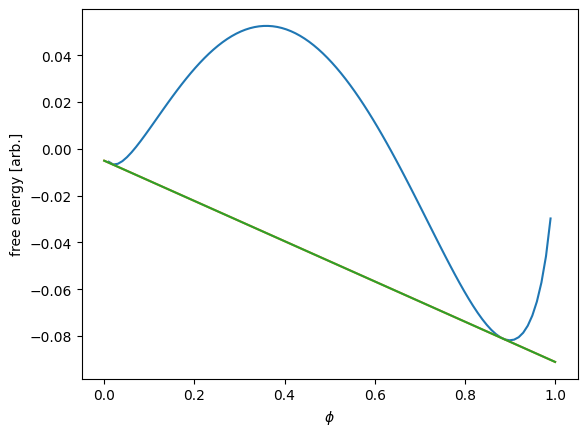

In [4]:
coeffs = [2.0, 3.0, 1.0]
psi, flag = binodal(coeffs, eps=1e-15)
phi = np.linspace(0, 1, 100)
plt.xlabel('$\phi$')
plt.ylabel('free energy [arb.]')
plt.plot(phi, free_energy(phi, coeffs))
plt.plot(phi, fe_tangent(phi, psi[0], coeffs))
plt.plot(phi, fe_tangent(phi, psi[1], coeffs))

## 誤差の確認

# 相図作成

In [5]:
@noglobal
def phase_diagram(max_chi, N1, N2, dev=50, eps=1e-15):
    """
    Create the phase diagram.

    Parameters:
    coeffs (list): Coefficients for the phase diagram creation.

    Returns:
    None. Plots the phase diagram.
    """
    try:
        # 計算を効率良くするために臨界点を計算しておく
        phi_c = np.sqrt(N2)/(np.sqrt(N1)+np.sqrt(N2))
        min_chi = (np.sqrt(N1)+np.sqrt(N2))**2/(2*N1*N2)

        # chiの刻み幅
        delta_chi = (max_chi-min_chi) / dev
        chi = min_chi

        binodal_line = []
        spinodal_line = []

        binodal_line.append([phi_c, chi])
        spinodal_line.append([phi_c, chi])

        # 最初の共存線を得るための初期値
        psi = spinodal([chi+delta_chi, N1, N2])

        while(chi < max_chi):
            chi = chi + delta_chi
            coeffs = [chi, N1, N2]
            psi, flag = binodal(coeffs, psi, eps=eps)
            if(flag): # binodal()計算が収束したときのみデータを追加
                binodal_line.append([psi[0], chi])
                binodal_line.append([psi[1], chi])
                phi_sp = spinodal([chi, N1, N2])
                spinodal_line.append([phi_sp[0], chi])
                spinodal_line.append([phi_sp[1], chi])
            else: # 収束しない場合さらに大きなchiでも収束しないので打ち切る
                break
        return np.array(sorted(spinodal_line)), np.array(sorted(binodal_line)) # phi についてソートしておくと共存線書きやすい
    except Exception as e:
        print(f"Failed to plot the phase diagram: {e}")

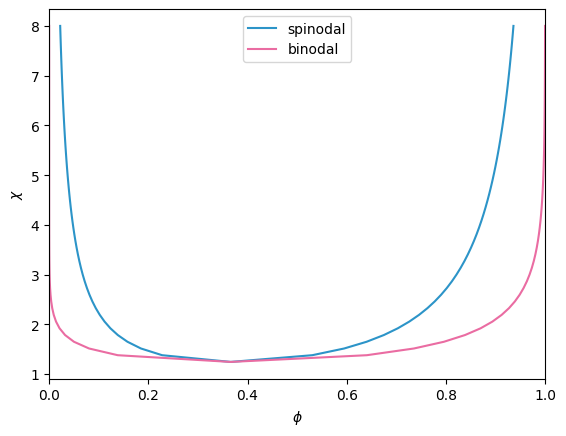

In [6]:
max_chi = 8
N1 = 3
N2 = 1

sp_line, bi_line = phase_diagram(max_chi, N1, N2)
plt.xlabel('$\phi$')
plt.ylabel('$\chi$')
plt.xlim([0, 1])
plt.plot(sp_line[:, 0], sp_line[:, 1], color=dora[0], label='spinodal')
plt.plot(bi_line[:, 0], bi_line[:, 1], color=dora[1], label='binodal')
plt.legend()